# Identification Of Counterfeit Medicine Based On Appearance

## Introduction

This notebook presents a TensorFlow model that identifies counterfeit medicine based on appearance.  Specifically, the model receives image data as input and predicts the name (e.g., "Medithyl (10 mg)") and source (e.g., "Counterfeit D") of medicine in an image.  Organizations such as the [FDA](https://www.fda.gov/drugs/buying-using-medicine-safely/counterfeit-medicine) and [AAFP](https://www.aafp.org/fpm/2007/0300/p36.html) recommend such visual inspection as a simple method to identify counterfeits, which remain a persistent and deadly [global health risk](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4455087/).

<img src="https://www.pbs.org/wgbh/nova/media/images/lipitor-pills.width-1500.jpg" alt="Real Medicine Examples" width="400"/>

**Figure 1:** Counterfeit Lipitor pills (left) sit next to genuine examples (right).  This image and an associated article about counterfeit medicine are available on [PBS.org](https://www.pbs.org/wgbh/nova/article/uncovering-counterfeit-medicines/).

Due to limited availability of real-life counterfeit medicine images, our model is trained using approximately 5,100 near-photorealistic synthetic images.  These images were procedurally generated using Python, Blender, and GIMP. Ground truth labels were concurrently generated for each image and saved in a CSV file.

## Summary Of Results

Analysis of our model's evaluation metrics shows that the model can effectively identify medicines in our dataset while differentiating between authentic and counterfeit medicines.  The accuracy of medicine name predictions and recall of counterfeit source predictions both converged to greater than 99% in about fifteen epochs.  Careful weighting of losses also effectively ensured that counterfeit medicines were detected as often as possible without significantly impacting the recall of authentic medicines.  Additional details and statistics are provided in the full analysis below.

In [ ]:
import itertools
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import embedding_lookup
from tensorflow.python.keras.utils import metrics_utils

In [ ]:
DATASET_DIR = "/root/.keras/datasets/tensorflow_demo"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
CSV_PATH = os.path.join(DATASET_DIR, "images.csv")

## Data Exploration

In [ ]:
# Download the dataset.

tf.keras.utils.get_file(
    "tensorflow_demo.tar.gz", "https://bit.ly/tensorflow_demo", extract=True)

1209114624/1209110495 [==============================] - 38s 0us/step


'/root/.keras/datasets/tensorflow_demo.tar.gz'

In [ ]:
# Quickly explore the dataset.

df = pd.read_csv(CSV_PATH)
print(df)

            image     medicine_name  medicine_source
0     IMAGE_1.png  Medithyl (10 mg)  Alias Meds Inc.
1     IMAGE_2.png  Medithyl (10 mg)  Alias Meds Inc.
2     IMAGE_3.png  Medithyl (10 mg)  Alias Meds Inc.
3     IMAGE_4.png  Medithyl (10 mg)  Alias Meds Inc.
4     IMAGE_5.png  Medithyl (10 mg)  Alias Meds Inc.
...           ...               ...              ...
5095   IMAGE_5095  Medithyl (30 mg)    Counterfeit D
5096   IMAGE_5096  Medithyl (30 mg)    Counterfeit D
5097   IMAGE_5097  Medithyl (30 mg)    Counterfeit D
5098   IMAGE_5098  Medithyl (30 mg)    Counterfeit D
5099   IMAGE_5099  Medithyl (30 mg)    Counterfeit D

[5100 rows x 3 columns]


In [ ]:
# There are three unique labels in the medicine_name column and five
# unique labels in the medicine_source column.

print("Unique medicine_name labels: "
      + str([n for n in df.medicine_name.unique() if pd.notna(n)]))

print("Unique medicine_source labels: "
      + str([s for s in df.medicine_source.unique() if pd.notna(s)]))

Unique medicine_name labels: ['Medithyl (10 mg)', 'Medithyl (20 mg)', 'Medithyl (30 mg)']
Unique medicine_source labels: ['Alias Meds Inc.', 'Counterfeit A', 'Counterfeit B', 'Counterfeit C', 'Counterfeit D']


In [ ]:
# Define functions to display example images from the dataset.

def display_example_image(df, name_label, source_label, ax):
    """Displays an example image from dataframe df in ax."""
    # Find the first row in df that has the given labels in its
    # medicine_name and medicine_source columns, and show the image from
    # that row in ax.
    row_index = ((df.medicine_name.values == name_label) &
                 (df.medicine_source.values == source_label)).argmax()
    row = df.iloc[row_index]
    img = mpimg.imread(os.path.join(IMAGES_DIR, row.image))
    ax.imshow(img)

    # Set title and axis properties.
    title_text = "\n".join([row.medicine_name, row.medicine_source])
    ax.set_title(title_text)
    ax.set_axis_off()


def display_example_images(df, axs):
    """Displays example images from dataframe df in axs."""
    # Get unique medicine names and sources from dataframe df.
    names = [n for n in df.medicine_name.unique() if pd.notna(n)]
    sources = [s for s in df.medicine_source.unique() if pd.notna(s)]

    # Plot an example image for each medicine name and source.
    for index, source in enumerate(sources):
        display_example_image(df, names[index % len(names)], source, axs[index])

Example images from the dataset are displayed below.  The names and sources of medicines can be visually differentiated as follows:

**Medicine Name**

1. Medithyl (10 mg): imprint code MD10
2. Medithyl (20 mg): imprint code MD20
3. Medithyl (30 mg): imprint code MD30

**Medicine Source**

1. Alias Meds Inc.: Medicine is authentic and represents the baseline appearance against which counterfeits are compared.
2. Counterfeit A: Medicine has a slightly smoother surface and a larger imprint code with a different font.
3. Counterfeit B: Medicine has a less glossy surface and more pronounced surface pitting defects.  
4. Counterfeit C: Medicine has a smoother and glossier surface, slightly more surface pitting, and a larger imprint code with a different font.
5. Counterfeit D: Medicine is nearly identical to the authentic medicine; it simply has a slightly larger imprint code.


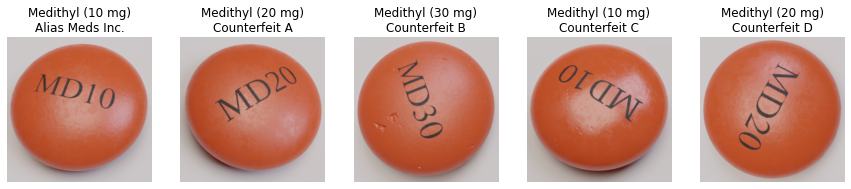

In [ ]:
# Display example images corresponding to all medicine names and sources.

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
display_example_images(df, axs)

In [ ]:
# Define a function to plot cross-tabulated data.

def display_crosstab_bar_plot(crosstab_data, title):
    """Displays a bar plot of crosstab_data."""
    # Create plot.
    ax = crosstab_data.plot(kind='bar', figsize=(6, 4.5))

    # Set title and axis properties.
    ax.set_title(title)
    ax.set_xlabel(crosstab_data.axes[0].name)
    ax.set_ylabel("Count")

    # Set legend properties.
    ax.legend(loc='upper right', title=crosstab_data.axes[1].name)

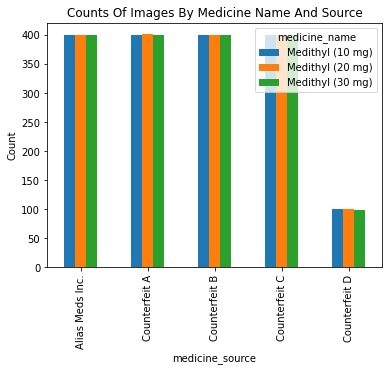

In [ ]:
# Plot the counts of all combinations of medicine names and sources.  The
# class imbalance in the dataset will not significantly impact training.

crosstab_data = pd.crosstab(df.medicine_source, df.medicine_name)
display_crosstab_bar_plot(
    crosstab_data, "Counts Of Images By Medicine Name And Source")

## Data Cleaning

During data synthesis, random errors were intentionally introduced into the dataset.  Data cleaning steps are performed now to correct these errors.

In [ ]:
# Concatenate ".png" onto image labels that don't have file extensions to
# ensure that ImageDataGenerator can find all image files.

missing_ext_mask = ~df.image.str.lower().str.endswith(".png")
print("Added '.png' onto image labels in these rows:\n"
      + str(df[missing_ext_mask]))

df.loc[missing_ext_mask, "image"] += ".png"

Added '.png' onto image labels in these rows:
           image     medicine_name medicine_source
5001  IMAGE_5001  Medithyl (30 mg)   Counterfeit D
5002  IMAGE_5002  Medithyl (30 mg)   Counterfeit D
5003  IMAGE_5003  Medithyl (30 mg)   Counterfeit D
5004  IMAGE_5004  Medithyl (30 mg)   Counterfeit D
5005  IMAGE_5005  Medithyl (30 mg)   Counterfeit D
...          ...               ...             ...
5095  IMAGE_5095  Medithyl (30 mg)   Counterfeit D
5096  IMAGE_5096  Medithyl (30 mg)   Counterfeit D
5097  IMAGE_5097  Medithyl (30 mg)   Counterfeit D
5098  IMAGE_5098  Medithyl (30 mg)   Counterfeit D
5099  IMAGE_5099  Medithyl (30 mg)   Counterfeit D

[99 rows x 3 columns]


In [ ]:
# Define a function to determine whether image names correspond to
# valid, existing files with non-zero size.

def image_is_valid(image_name):
    """Determines if a valid file named image_name is in IMAGES_DIR."""
    image_path = os.path.join(IMAGES_DIR, image_name)
    return os.path.isfile(image_path) and os.path.getsize(image_path) > 0

In [ ]:
# Drop rows with invalid images.

invalid_image_mask = ~df.apply(lambda x: image_is_valid(x.image), axis=1)
print("Dropped these rows with invalid images:\n" + str(df[invalid_image_mask]))

df = df[~invalid_image_mask]

Dropped these rows with invalid images:
               image     medicine_name  medicine_source
60      IMAGE_61.png  Medithyl (10 mg)  Alias Meds Inc.
3185  IMAGE_3185.png  Medithyl (20 mg)    Counterfeit B
4630  IMAGE_4630.png  Medithyl (30 mg)    Counterfeit C


In [ ]:
# Drop rows with missing labels.

print("Dropped these rows with missing labels:\n"
      + str(df[df.isnull().any(axis=1)]))

df.dropna(inplace=True)

Dropped these rows with missing labels:
               image medicine_name medicine_source
1457  IMAGE_1458.png           NaN             NaN
2800  IMAGE_2800.png           NaN             NaN
3956  IMAGE_3956.png           NaN             NaN
4401  IMAGE_4401.png           NaN             NaN


In [ ]:
# Drop rows with duplicate image labels.

print("Dropped these rows with duplicate image labels:\n"
      + str(df[df.duplicated(subset="image", keep=False)]))

df.drop_duplicates(subset="image", keep=False, inplace=True)

Dropped these rows with duplicate image labels:
               image     medicine_name medicine_source
2000  IMAGE_2001.png  Medithyl (20 mg)   Counterfeit A
2001  IMAGE_2001.png  Medithyl (30 mg)   Counterfeit A


## Final Data Preparation

In [ ]:
# Encode labels in the medicine_name and medicine_source columns as
# integers to ensure proper training.

name_encoder = LabelEncoder()
df.medicine_name = name_encoder.fit_transform(df.medicine_name)

source_encoder = LabelEncoder()
df.medicine_source = source_encoder.fit_transform(df.medicine_source)

print("Dataframe after encoding medicine names and sources:\n" + str(df))

Dataframe after encoding medicine names and sources:
               image  medicine_name  medicine_source
0        IMAGE_1.png              0                0
1        IMAGE_2.png              0                0
2        IMAGE_3.png              0                0
3        IMAGE_4.png              0                0
4        IMAGE_5.png              0                0
...              ...            ...              ...
5095  IMAGE_5095.png              2                4
5096  IMAGE_5096.png              2                4
5097  IMAGE_5097.png              2                4
5098  IMAGE_5098.png              2                4
5099  IMAGE_5099.png              2                4

[5091 rows x 3 columns]


In [ ]:
# Define a function to generate a stratified sample of items from a
# dataframe, with stratification based on specified dataframe columns.

def stratified_sample(df, frac, *stratifying_columns):
    """Returns a stratified sample of items from dataframe df."""
    return df.groupby(list(stratifying_columns)).apply(
        lambda x: x.sample(frac=frac)).sample(frac=1.0).reset_index(drop=True)

In [ ]:
# Use stratified sampling to split the dataframe into training
# (df_train), validation (df_val), and test (df_test) sets.

df_test = stratified_sample(df, 0.20, "medicine_name", "medicine_source")
df_train = df[~df.image.isin(df_test.image)]
df_valid = stratified_sample(df_train, 0.25, "medicine_name", "medicine_source")
df_train = df_train[~df_train.image.isin(df_valid.image)].reset_index(drop=True)

## Classes Used During Training

The TensorFlow model in this notebook requires custom loss and metric classes, which are defined below.

In [ ]:
# Define a loss function that can apply per-class weights for models with
# multiple output layers (model.fit's class_weight parameter does not
# work with such multi-output models).

class WeightedSparseCategoricalCrossentropy(SparseCategoricalCrossentropy):
    """Computes weighted crossentropy loss between labels & predictions.

    See base class for more details: http://bit.ly/3rew44R

    Example usage with the `compile()` API:
    If a column has three integer labels (0, 1, and 2), then label 1 can
    be weighted 1.5 times as much as the other labels as follows:

    ```python
    model.compile(
        optimizer='sgd',
        loss=WeightedSparseCategoricalCrossentropy([1.0, 1.5, 1.0]))
    ```

    Attributes:
        class_weights: A list of float weights whose indices correspond
            to the integer values of sparse categorical labels.
        name: An optional string name for the op that defaults to
            "weighted_sparse_categorical_crossentropy".
    """

    def __init__(self,
                 class_weights,
                 name="weighted_sparse_categorical_crossentropy",
                 **kwargs):
        """Initializes WeightedSparseCategoricalCrossentropy instance."""
        super().__init__(name=name, **kwargs)
        self.class_weights = tf.convert_to_tensor(class_weights, np.float32)

    def call(self, y_true, y_pred):
        """Returns weighted crossentropy losses."""
        losses = super().call(y_true, y_pred)
        weighted_losses = tf.math.multiply(
            losses, embedding_lookup(self.class_weights, tf.squeeze(y_true)))
        return weighted_losses

    def get_config(self):
        """Returns the config dictionary of the instance."""
        return super().get_config().copy().update(
            {"class_weights": self.class_weights})

In [ ]:
# Define a metric function that calculates overall or per-class recall
# for sparse categorical labels from models with multiple output layers.

class SparseCategoricalRecall(Recall):
    """Computes recall of predictions with respect to sparse categorical
    labels.

    See base class for more details: http://bit.ly/3uE1hAj

    Example usage with the `compile()` API:
    Recall can be calculated for only the class with label 2 and for all
    classes as follows:

    ```python
    model.compile(
        optimizer='sgd', loss='categorical_crossentropy',
        metrics=[
            SparseCategoricalRecall(name="recall_overall"),
            SparseCategoricalRecall(class_id=2, name="recall_class_2")])
    ```

    Attributes:
        class_id: An optional integer class ID for which to calculate
            recall.  Default value is None, which will cause the overall
            recall to be calculated for all classes.
        name: An optional string name for the op that defaults to
            "sparse_categorical_recall".
    """

    def __init__(self,
                 class_id=None,
                 name="sparse_categorical_recall",
                 **kwargs):
        """Initializes SparseCategoricalRecall instance."""
        super().__init__(class_id=class_id, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Returns op to update instance's confusion matrix variables."""
        y_pred = tf.math.argmax(y_pred, axis=1)
        y_true = tf.squeeze(y_true)

        if self.class_id is None:
            y_pred = tf.math.equal(y_pred, y_true)
            y_true = tf.fill(tf.shape(y_true), True, name=None)
        else:
            y_pred = tf.math.equal(y_pred, self.class_id)
            y_true = tf.math.equal(y_true, self.class_id)

        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES:
                    self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES:
                   self.false_negatives
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            top_k=self.top_k,
            class_id=None,
            sample_weight=sample_weight)

## Objects Used During Training

The TensorFlow model in this notebook is trained multiple times.  Objects that are used during training runs are assigned values below.  

In [ ]:
# Assign values to useful training constants.

BATCH_SIZE = 32
NUM_INITIAL_EPOCHS = 10
NUM_FINE_EPOCHS = 10

In [ ]:
# Assign values to generators that are used as arguments for model.fit
# and model.evaluate.

generator_kwargs = {"batch_size": BATCH_SIZE,
                    "class_mode": 'multi_output',
                    "directory": IMAGES_DIR,
                    "target_size": (224, 224),
                    "x_col": "image",
                    "y_col": ["medicine_name", "medicine_source"]}

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=180,
    shear_range=0.10)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, **generator_kwargs)
valid_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_valid, shuffle=False, **generator_kwargs)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test, shuffle=False, **generator_kwargs)

Found 3051 validated image filenames.
Found 1020 validated image filenames.
Found 1020 validated image filenames.


In [ ]:
# Assign values to a dictionary that is used as model.fit's metrics
# argument, and return that dictionary using the get_metrics function.

def get_metrics():
    """Returns a dict of metrics to calculate during model training."""
    return {"medicine_name_prediction": ['sparse_categorical_accuracy'],
            "medicine_source_prediction": [
                SparseCategoricalRecall(
                    class_id=source_encoder.transform(["Alias Meds Inc."])[0],
                    name="recall_alias_meds_inc"),
                SparseCategoricalRecall(
                    class_id=source_encoder.transform(["Counterfeit A"])[0],
                    name="recall_counterfeit_a"),
                SparseCategoricalRecall(
                    class_id=source_encoder.transform(["Counterfeit B"])[0],
                    name="recall_counterfeit_b"),
                SparseCategoricalRecall(
                    class_id=source_encoder.transform(["Counterfeit C"])[0],
                    name="recall_counterfeit_c"),
                SparseCategoricalRecall(
                    class_id=source_encoder.transform(["Counterfeit D"])[0],
                    name="recall_counterfeit_d"),
                SparseCategoricalRecall(name="recall_overall")]}

## Creation And Training Of Model

We now create and train a model that is based on EfficientNet and aided by transfer learning.  The model has one input layer that receives image data and two output layers.  One output layer predicts a medicine's name (e.g., "Medithyl (10 mg)"), and the other output layer predicts a medicine's source (e.g., "Counterfeit D").

Two training runs are performed on the model.  During the first run, the model is rapidly trained with frozen EfficientNet layers.  During the second run, the model is slowly fine-tuned with unfrozen EfficientNet layers.

In [ ]:
# Define a function to build a modified EfficientNet model.

def build_modified_efficientnet_model(df, *column_names):
    """Builds a version of EfficientNetB0 with new output layers.

    Builds a version of EfficientNetB0 that has an output layer for each
    name in column_names.

    Args:
        df: A pandas dataframe.
        *column_names: Strings representing names of columns in df, where
            the named columns have sparse categorical labels.

    Returns:
        A TensorFlow model based on EfficientNetB0 that has one output
            layer for each name in column_names.  The named columns must
            be in dataframe df and have sparse categorical labels.  The
            number of nodes in an output layer is the number of unique
            labels in the corresponding named column.  Each output layer
            has softmax activation.
    """

    # Define input layer.
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

    # Define base model.
    base_model = EfficientNetB0(
        include_top=False, input_tensor=input_layer, weights='imagenet')
    base_model.trainable = False

    # Add layers to predict labels from each named column.
    output_layers = []
    for column_name in column_names:
        col_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        col_layer = tf.keras.layers.BatchNormalization()(col_layer)
        col_layer = tf.keras.layers.Dropout(0.2)(col_layer)
        output_layer = tf.keras.layers.Dense(
            df[column_name].nunique(),
            activation='softmax',
            name=column_name + "_prediction")(col_layer)
        output_layers.append(output_layer)

    return tf.keras.Model(
        inputs=[input_layer], outputs=output_layers, name="EffNetModel")

In [ ]:
# Perform initial training using our model with frozen EfficientNet
# layers.

model = build_modified_efficientnet_model(
    df, "medicine_name", "medicine_source")

model.compile(
    loss=SparseCategoricalCrossentropy(),
    loss_weights=[1.0, 3.0],
    metrics=get_metrics(),
    optimizer=tf.keras.optimizers.Nadam(
        learning_rate=5e-3, decay=1e-3, epsilon=0.5))

early_stopping_val_loss = EarlyStopping(
    min_delta=0.1, monitor="val_loss", patience=2, restore_best_weights=True)

init_history = model.fit(
    train_generator,
    callbacks=[early_stopping_val_loss],
    epochs=NUM_INITIAL_EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE,
    verbose=0)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Perform additional fine-tuning using our model with unfrozen
# EfficientNet layers.

# Unfreeze layers of the base EfficientNet model (except
# BatchNormalization layers).
for layer in model.layers[:-8]:
    layer.trainable = not isinstance(layer, tf.keras.layers.BatchNormalization)

# Recompile the model with fine-tuning arguments.
model.compile(
    # Losses from sources Counterfeit A and Counterfeit D are weighted to
    # ensure good final recall for these counterfeits, which are
    # particularly similar to authentic medicine from Alias Meds Inc.
    loss=[SparseCategoricalCrossentropy(),
          WeightedSparseCategoricalCrossentropy(
              np.array([1.0, 1.1, 1.0, 1.0, 1.25]))],
    metrics=get_metrics(),
    # Use a smaller learning rate during fine-tuning.
    optimizer=tf.keras.optimizers.Nadam(
        learning_rate=3e-5, decay=1e-3, epsilon=7.5e-3))

# Begin fine-tuning after the restored epoch if the EarlyStopping
# callback stopped training.  Begin at the current epoch otherwise.
initial_fine_epoch = (
    early_stopping_val_loss.stopped_epoch - early_stopping_val_loss.patience + 1
    if early_stopping_val_loss.stopped_epoch
    else NUM_INITIAL_EPOCHS)

# Use stricter early stopping criteria during fine-tuning.
fine_stopping_val_loss = EarlyStopping(
    min_delta=0.01, monitor="val_loss", patience=4, restore_best_weights=True)

# Perform fine-tuning on the model.
fine_history = model.fit(
    train_generator,
    callbacks=[fine_stopping_val_loss],
    epochs=initial_fine_epoch + NUM_FINE_EPOCHS,
    initial_epoch=initial_fine_epoch,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // BATCH_SIZE,
    verbose=0)

In [ ]:
# Define a function to display training and validation metrics.

def display_train_and_val_metrics(
    train_metrics, val_metrics, ax, title, y_label):
    """Displays train_metrics and val_metrics in ax."""
    # Plot training and validation metrics.
    ax.plot(val_metrics, color='blue')
    ax.plot(train_metrics, color='red')

    # Set title properties.
    ax.set_title(title)

    # Set x-axis properties.
    num_epochs = len(train_metrics)
    ax.set_xlim(0.0, num_epochs)
    ax.set_xticks(np.arange(0, num_epochs + 1, 2.0))
    ax.set_xlabel("Epoch")

    # Set y-axis properties.
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel(y_label)

    # Indicate where fine-tuning begins.
    ax.plot([initial_fine_epoch - 1, initial_fine_epoch - 1],
            plt.ylim(), color='green')

    # Set legend properties.
    ax.legend(["Validation", "Training", "Fine-Tuning Begins"],
              loc='lower right')

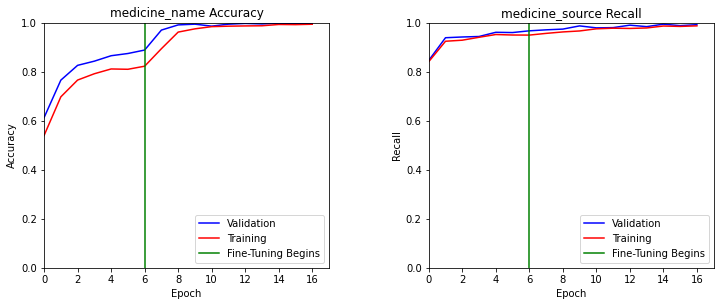

In [ ]:
# Plot training and validation metrics.

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
fig.subplots_adjust(wspace=0.35)

# Determine the upper indices to slice history lists (to exclude epochs
# after weight restorations by EarlyStopping callbacks).
init_upper_index = initial_fine_epoch
fine_upper_index = (
    (fine_stopping_val_loss.stopped_epoch
     - fine_stopping_val_loss.patience
     - init_upper_index + 1)
    if fine_stopping_val_loss.stopped_epoch
    else NUM_FINE_EPOCHS)

# Combine the histories of initial training and fine-tuning.
history = {key: init_history.history[key][:init_upper_index]
                + fine_history.history[key][:fine_upper_index]
           for key in init_history.history}

# Plot the accuracy of medicine_name predictions.
display_train_and_val_metrics(
    history["medicine_name_prediction_sparse_categorical_accuracy"],
    history["val_medicine_name_prediction_sparse_categorical_accuracy"],
    axs[0], "medicine_name Accuracy", "Accuracy")

# Plot the recall of medicine_source predictions.
display_train_and_val_metrics(
    history["medicine_source_prediction_recall_overall"],
    history["val_medicine_source_prediction_recall_overall"],
    axs[1], "medicine_source Recall", "Recall")

## Evaluation Of Model

In [ ]:
# Calculate metrics using the trained model and test dataset.

evaluation = model.evaluate(test_generator, verbose=0)

print("\nMetrics (test dataset):")
for metric_name, metric_value in zip(model.metrics_names, evaluation):
    print("{}: {}".format(metric_name, metric_value))


Metrics (test dataset):
loss: 0.031497448682785034
medicine_name_prediction_loss: 0.006489028688520193
medicine_source_prediction_loss: 0.025008417665958405
medicine_name_prediction_sparse_categorical_accuracy: 1.0
medicine_source_prediction_recall_alias_meds_inc: 0.9916666746139526
medicine_source_prediction_recall_counterfeit_a: 1.0
medicine_source_prediction_recall_counterfeit_b: 1.0
medicine_source_prediction_recall_counterfeit_c: 0.9958333373069763
medicine_source_prediction_recall_counterfeit_d: 1.0
medicine_source_prediction_recall_overall: 0.9970588088035583


In [ ]:
# Generate predictions using the trained model and test dataset.

predictions = model.predict(test_generator)

In [ ]:
# Define a function to display a confusion matrix.

def display_confusion_matrix(matrix, ax, title, tick_labels):
    """Displays a confusion matrix in ax."""
    # Show confusion matrix.
    cax = ax.matshow(matrix, cmap='gray')

    # Set title properties.
    ax.set_title("Confusion Matrix\n" + title)

    # Set x-axis properties.
    ax.set_xlabel("Predicted Label", labelpad=10)
    ax.xaxis.tick_bottom()
    ax.set_xticklabels(
        [""] + list(tick_labels), rotation='vertical', verticalalignment='top')

    # Set y-axis properties.
    ax.set_ylabel("True Label", labelpad=10)
    ax.set_yticklabels([""] + list(tick_labels))

    # Display prediction counts in matrix.
    color_limit = ((matrix.max() - matrix.min()) / 2) + matrix.min()
    for i, j in itertools.product(range(matrix.shape[0]), repeat=2):
        ax.text(j, i, "{:,}".format(matrix[i, j]),
                color='black' if matrix[i, j] > color_limit else 'white',
                horizontalalignment='center')

    # Set color bar properties.
    fig.colorbar(cax, ax=ax)

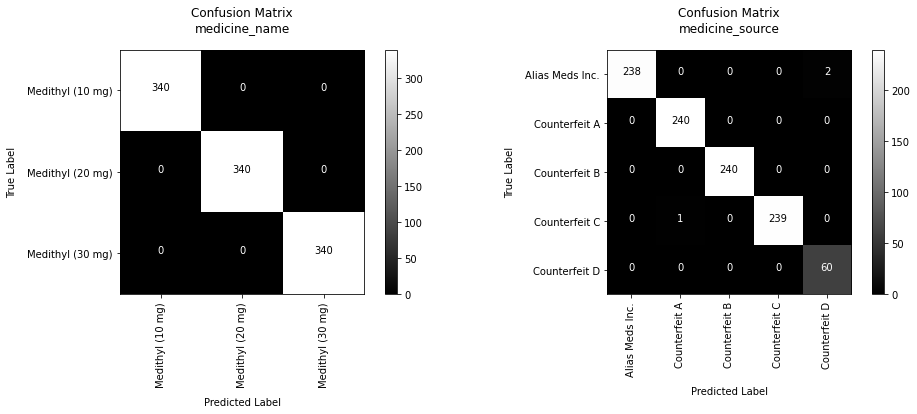

In [ ]:
# Display confusion matrices for predictions.

fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))

# Create confusion matrix for medicine_name predictions.
name_matrix = confusion_matrix(
    df_test.medicine_name, predictions[0].argmax(axis=-1), normalize=None)
display_confusion_matrix(
    name_matrix, axs[0], "medicine_name", name_encoder.classes_)

# Create confusion matrix for medicine_source predictions.
source_matrix = confusion_matrix(
    df_test.medicine_source, predictions[1].argmax(axis=-1), normalize=None)
display_confusion_matrix(
    source_matrix, axs[1], "medicine_source", source_encoder.classes_)

## Conclusions

Analysis of our model's evaluation metrics shows that the model can effectively identify medicines in our dataset while differentiating between authentic and counterfeit medicines.  The accuracy of medicine name predictions and recall of counterfeit source predictions both surpassed 99% in about ten epochs and converged shortly thereafter.  However, the small dataset and similarity of images (with regard to lighting, backgrounds, etc.) suggest that training with a larger and more varied dataset could help determine the utility of such a model in real-world scenarios.

Careful weighting of losses also effectively adjusted recall during training.  Counterfeits A and D were specifically given increased loss weights compared to other samples due to the difficulty of differentiating them from authentic medicines.  The number of authentic medicine images that are misclassified as Counterfeit A or D during typical training runs increases by 1-2% with this weighting process, but such misclassification is a worthwhile trade-off to ensure that counterfeit medicines are identified as often as possible.

Overall, it is important to note that, while this model may help identify the source of counterfeit medicine, its utility is constrained by the counterfeit sources on which it is trained.  Alternatively, a model such as an autoencoder could identify the counterfeit nature of a medicine (without regard to its exact source) even for previously unseen counterfeit medicines.  Identification of both the authenticity and source of a medicine in real-world cases could therefore most likely benefit from a more complex model or the simultaneous use of multiple complimentary types of machine learning models.

## Credits

This notebook and all associated files were created by Davin C. (dc.ghub@gmail.com)

## License

This notebook and all associated files are Copyright (C) 2021 Davin C. (dc.ghub@gmail.com).

